In [30]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from models import SIREN
from tqdm import tqdm
import os
from icecream import ic

import config

# Assume models are saved in a list of file paths
group_name = "earthquake_default"

ind = 1
model_paths = []
while os.path.exists(config.model_dir + f'{group_name}/inr_eval_{ind}.pth'):
    model_paths.append(config.model_dir + f'{group_name}/inr_eval_{ind}.pth')
    ind += 1


config.seed_everything(43)

# Function to extract features
def extract_weights(model):
    return torch.cat([p.data.view(-1) for p in model.parameters()])

# Collect all features
all_weights = []

for idx, model_path in enumerate(tqdm(model_paths)):
    # Load the model
    net = SIREN(in_features=3, out_features=1, init_features=64, num_res=5)
    net.load_state_dict(torch.load(model_path))
    weights = extract_weights(net)
    all_weights.append(weights.cpu().numpy())

# Concatenate features from all models
all_weights = np.asarray(all_weights)

  0%|          | 0/597 [00:00<?, ?it/s]/tmp/ipykernel_252714/1994133795.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_path))
100%

In [32]:
# Apply t-SNE
from io import StringIO
import sys

from sklearn.decomposition import PCA
# pca = PCA(n_components=100)
# all_weights = pca.fit_transform(all_weights)
def compute_tsne(all_weights, perplexity=30, n_iter=3000):
    # catch stdout without print
    tsne = TSNE(n_components=2, random_state=45, perplexity=perplexity, n_iter=n_iter)
    tsne_results = tsne.fit_transform(all_weights)
    return tsne_results

In [33]:
# compare tsne graphs with different perplexity range(15, 300, 15)
# perplexity_range = np.arange(15, 300, 15)
# for perplexity in perplexity_range:
#     old_stdout = sys.stderr
#     sys.stderr = StringIO()
#     tsne_results = compute_tsne(all_weights, perplexity=perplexity)
#     sys.stderr = old_stdout
#     # Plotting (connect centroids with lines)
#     plt.figure(figsize=(10, 8), dpi=50)
#     prev_center = None
#     print(f'Perplexity: {perplexity}')
#     for idx in range(len(model_paths)):
#         x = tsne_results[idx, 0]
#         y = tsne_results[idx, 1]
#         plt.scatter(x, y, s=5, color='deepskyblue')
#         if prev_center:
#             plt.plot([prev_center[0], x], [prev_center[1], y], color='red', alpha=1)
#         prev_center = [x, y]
#     plt.show(block=False)

In [34]:
tsne_results = compute_tsne(all_weights, perplexity=50, n_iter=3000)

/home/spacefarers/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [35]:
# get the length between each centroid
lengths = []
angles = []
prev_angle = None
for idx in range(1, len(model_paths)):
    if idx != 1:
        lengths.append(np.linalg.norm(tsne_results[idx] - tsne_results[idx-1]))
    current_angle = np.arctan2(tsne_results[idx][1] - tsne_results[idx-1][1], tsne_results[idx][0] - tsne_results[idx-1][0])
    if prev_angle is not None:
        angles.append(abs(current_angle - prev_angle))
    prev_angle = current_angle

# normalize lengths and angles
lengths = np.array(lengths)
lengths = (lengths - np.min(lengths)) / (np.max(lengths) - np.min(lengths))
angles = np.array(angles)
angles = (angles - np.min(angles)) / (np.max(angles) - np.min(angles))
# compute score
length_weight = 0.8
angle_weight = 0.2

score = length_weight * lengths + angle_weight * angles
total_score = np.sum(score)

# select 50 models
num_selected = 50
target_score = total_score / num_selected
selected_models = []
current_score = 0
score_threshold = 0
# select every 10 selected models for rendering
double_selected = []
double_selected_count = 0
for idx in range(1, len(model_paths)-1):
    current_score += score[idx-1]
    if current_score >= score_threshold:
        selected_models.append(idx)
        if double_selected_count == 0:
            double_selected.append(idx)
            double_selected_count = 5
        double_selected_count -= 1
        score_threshold += target_score

In [36]:
len(model_paths)

597

In [37]:
len(selected_models)

50

In [38]:
print(selected_models)

[1, 11, 24, 35, 48, 60, 71, 84, 95, 108, 120, 131, 143, 155, 168, 180, 191, 202, 215, 227, 239, 250, 262, 275, 287, 299, 309, 321, 334, 347, 358, 369, 381, 393, 406, 418, 428, 440, 453, 466, 477, 487, 499, 512, 524, 536, 546, 559, 571, 583]


1
11
24
35
48
60
71
84
95
108
120
131
143
155
168
180
191
202
215
227
239
250
262
275
287
299
309
321
334
347
358
369
381
393
406
418
428
440
453
466
477
487
499
512
524
536
546
559
571
583


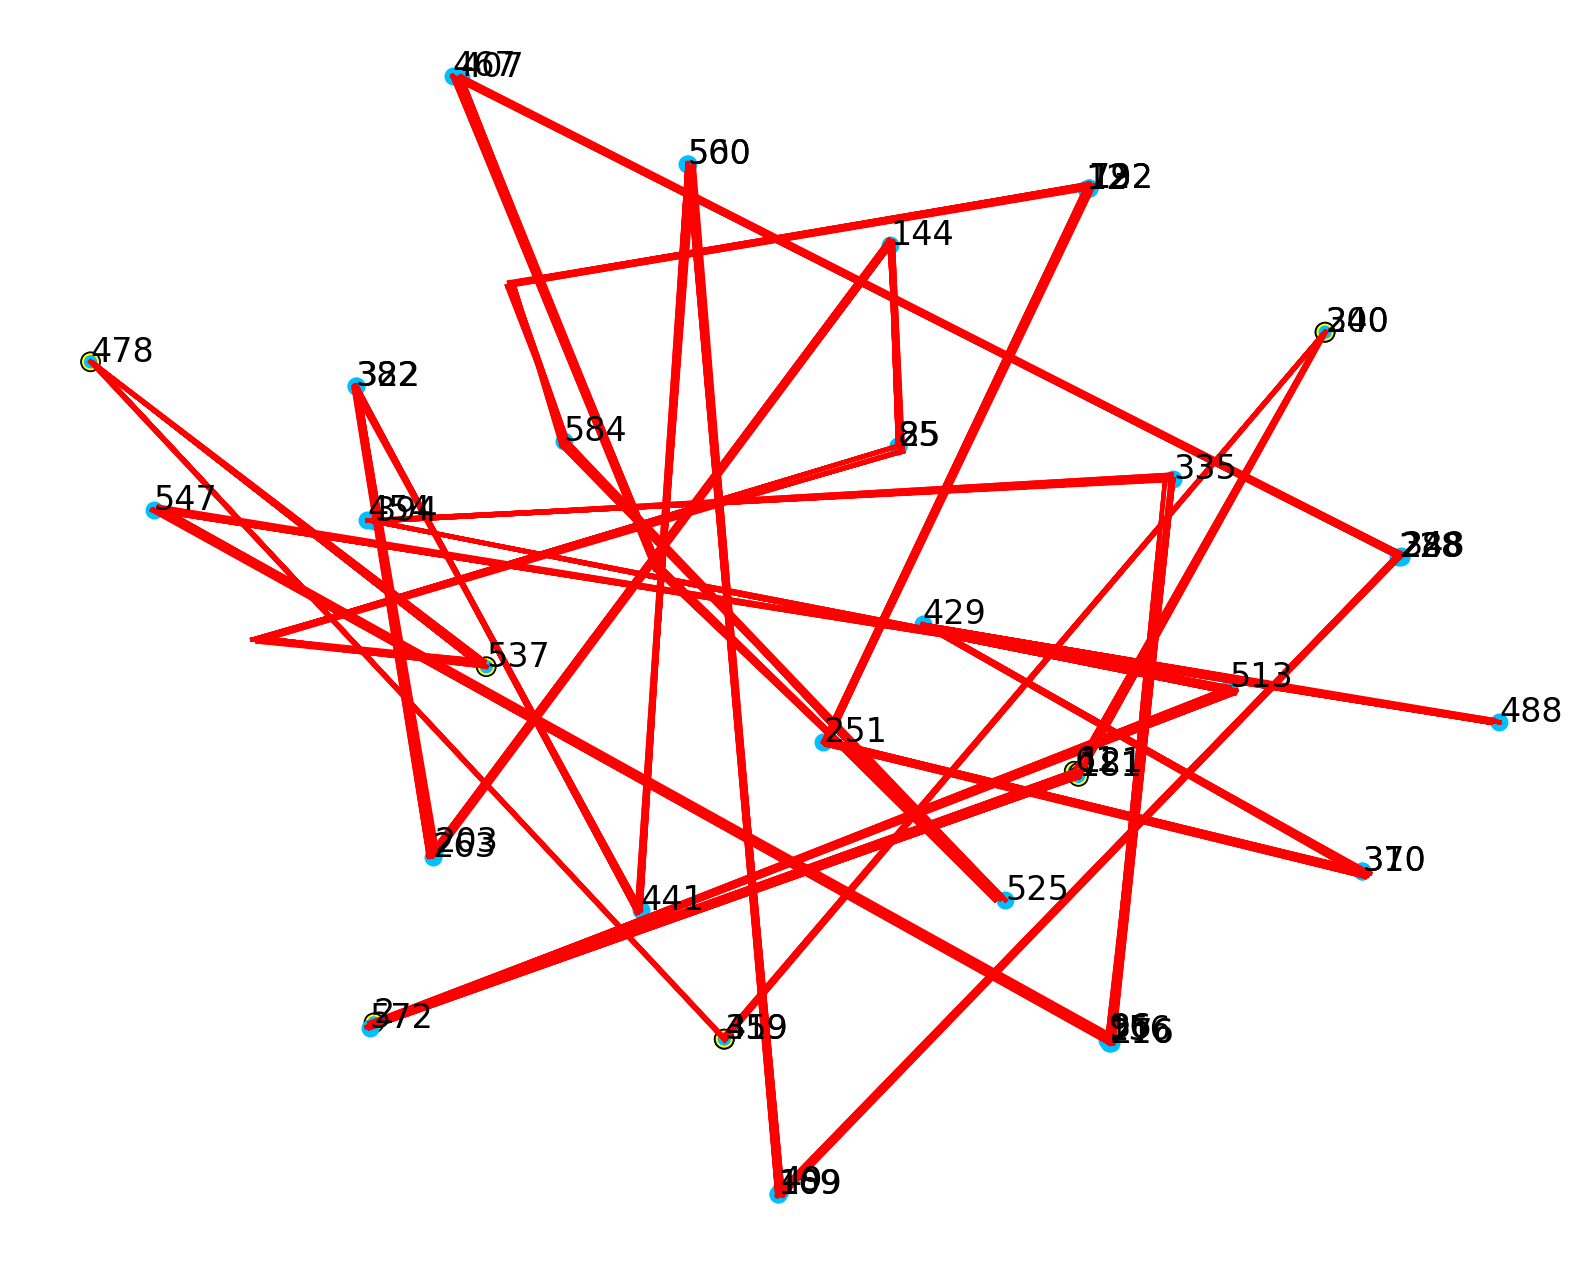

In [39]:
from matplotlib import patheffects

prev_center = []
# Plotting
plt.figure(figsize=(10, 8), dpi=200)

black = [0, 0, 0]
red = [1, 0, 0]

for idx in range(len(model_paths)):
    x = tsne_results[idx, 0]
    y = tsne_results[idx, 1]
    
    if idx in selected_models:
        print(idx)
        if idx in double_selected:
            plt.scatter(x, y, s=30, color='deepskyblue', edgecolors='yellow', linewidths=0.7, path_effects=[
            patheffects.withStroke(linewidth=2, foreground="black") # <-- Black outline!
        ])
        else:
            plt.scatter(x, y, s=30, color='deepskyblue')
        plt.annotate(f'{idx+1}', (x, y), fontsize=12, color='black')
    
    # draw line to previous center
    if prev_center:
        # line
        plt.plot([prev_center[0], x], [prev_center[1], y], color=red, alpha=1)
    prev_center = [x, y]

    # Annotate the plot with the label at the centroid
    # if idx % 20 == 0:
    #     plt.annotate(f'Model {idx+1}', (centroid_x, centroid_y), fontsize=12)
    
# remove axis ticks
plt.xticks([])
plt.yticks([])
plt.axis('off')

# get current x and y limits
x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

# r = 0.1
# plt.xlim(x0 - r*(x1-x0), x1 + r*(x1-x0))
# plt.ylim(y0 - r*(y1-y0), y1 + r*(y1-y0))
plt.savefig('tsne-inr.png')
plt.show(block=False)

In [40]:
print(double_selected)

[1, 60, 120, 180, 239, 299, 358, 418, 477, 536]


In [41]:
print(selected_models)

[1, 11, 24, 35, 48, 60, 71, 84, 95, 108, 120, 131, 143, 155, 168, 180, 191, 202, 215, 227, 239, 250, 262, 275, 287, 299, 309, 321, 334, 347, 358, 369, 381, 393, 406, 418, 428, 440, 453, 466, 477, 487, 499, 512, 524, 536, 546, 559, 571, 583]
